In [7]:
import tensorflow as tf
import numpy as np
import os
import dataloader
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import pywt
import pandas as pd

Using TensorFlow backend


c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


else
tensorflow


In [8]:
ROOT_DIR = '.'
DATA_DIR = 'BRATS_2018'
LABELED_DIR = 'MICCAI_BraTS_2018_Data_Training'
UNLABELED_DIR = 'MICCAI_BraTS_2018_Data_Validation'
LABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, LABELED_DIR)
UNLABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, UNLABELED_DIR)

BATCH_SIZE = 80
OFFSET = (35, 40)
BRAIN_SLICES = 8
NUM_CLASSES = 4
X_DTYPE = np.float32
Y_DTYPE = np.uint8
MAX_VALUE = 32767

In [9]:
paths, sizes = dataloader.load_dataset_paths(LABELED_PATH, UNLABELED_PATH)

In [10]:
train_brains, val_brains, test_brains, unlabeled_brains = paths

In [11]:
hgg_train_size, lgg_train_size, hgg_val_size, lgg_val_size = sizes 

In [12]:
hgg_train_size, lgg_train_size

(142, 50)

In [ ]:
len(train_brains), len(val_brains), len(test_brains)

(192, 49, 44)

In [15]:
def get_train_scan():
    for path in train_brains:
        path = dataloader.extend_path_from_last_part(path)
        t1 = nib.load(f'{path}_t1.nii').get_fdata(dtype=X_DTYPE)
        t1ce = nib.load(f'{path}_t1ce.nii').get_fdata(dtype=X_DTYPE)
        t2 = nib.load(f'{path}_t2.nii').get_fdata(dtype=X_DTYPE)
        flair = nib.load(f'{path}_flair.nii').get_fdata(dtype=X_DTYPE)
        seg = nib.load(f'{path}_seg.nii').get_fdata(dtype=X_DTYPE)

        batch_X = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, 4), dtype=X_DTYPE)
        batch_Y = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE), dtype=Y_DTYPE)

        for i in range(dataloader.BRAIN_FRAMES):
            batch_X[i, :, :, 0] = cv2.resize(t1[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            batch_X[i, :, :, 1] = cv2.resize(t1ce[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            batch_X[i, :, :, 2] = cv2.resize(t2[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            batch_X[i, :, :, 3] = cv2.resize(flair[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            y_map = dataloader.DataGenerator._map_labels(seg[:, :, i])
            batch_Y[i, :, :] = cv2.resize(y_map, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))

        batch_Y = tf.one_hot(batch_Y, 4, dtype=Y_DTYPE)
        batch_X = batch_X/MAX_VALUE

        yield batch_X, batch_Y

## Porównanie transformaty falkowej i Hartley'a

In [15]:
def _spectral_crop(input, oheight, owidth):
    cutoff_freq_h = int(np.ceil(oheight / 2))
    cutoff_freq_w = int(np.ceil(owidth / 2))

    if oheight % 2 == 1:
        if owidth % 2 == 1:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            bottom_left = input[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            bottom_right = input[:, -(cutoff_freq_h-1):, -(cutoff_freq_w-1):]
        else:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -cutoff_freq_w:]
            bottom_left = input[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            bottom_right = input[:, -(cutoff_freq_h-1):, -cutoff_freq_w:]
    else:
        if owidth % 2 == 1:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            bottom_left = input[:, -cutoff_freq_h:, :cutoff_freq_w]
            bottom_right = input[:, -cutoff_freq_h:, -(cutoff_freq_w-1):]
        else:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -cutoff_freq_w:]
            bottom_left = input[:, -cutoff_freq_h:, :cutoff_freq_w]
            bottom_right = input[:, -cutoff_freq_h:, -cutoff_freq_w:]

    top_combined = tf.concat((top_left, top_right), axis=-1)
    bottom_combined = tf.concat((bottom_left, bottom_right), axis=-1)
    all_together = tf.concat((top_combined, bottom_combined), axis=-2)

    return all_together

def _spectral_pad(input, output, oheight, owidth):
    cutoff_freq_h = int(np.ceil(oheight / 2))
    cutoff_freq_w = int(np.ceil(owidth / 2))

    pad = tf.zeros_like(input)

    if oheight % 2 == 1:
        if owidth % 2 == 1:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -(cutoff_freq_w-1):] = output[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            pad[:, -(cutoff_freq_h-1):, :cutoff_freq_w] = output[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            pad[:, -(cutoff_freq_h-1):, -(cutoff_freq_w-1):] = output[:, -(cutoff_freq_h-1):, -(cutoff_freq_w-1):]
        else:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -cutoff_freq_w:] = output[:, :cutoff_freq_h, -cutoff_freq_w:]
            pad[:, -(cutoff_freq_h-1):, :cutoff_freq_w] = output[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            pad[:, -(cutoff_freq_h-1):, -cutoff_freq_w:] = output[:, -(cutoff_freq_h-1):, -cutoff_freq_w:]
    else:
        if owidth % 2 == 1:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -(cutoff_freq_w-1):] = output[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            pad[:, -cutoff_freq_h:, :cutoff_freq_w] = output[:, -cutoff_freq_h:, :cutoff_freq_w]
            pad[:, -cutoff_freq_h:, -(cutoff_freq_w-1):] = output[:, -cutoff_freq_h:, -(cutoff_freq_w-1):]
        else:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -cutoff_freq_w:] = output[:, :cutoff_freq_h, -cutoff_freq_w:]
            pad[:, -cutoff_freq_h:, :cutoff_freq_w] = output[:, -cutoff_freq_h:, :cutoff_freq_w]
            pad[:, -cutoff_freq_h:, -cutoff_freq_w:] = output[:, -cutoff_freq_h:, -cutoff_freq_w:]

    return pad

def DiscreteHartleyTransform(input):
    fft = tf.signal.fft2d(tf.cast(input, tf.complex64))
    dht = tf.math.real(fft) - tf.math.imag(fft)
    return dht

@tf.custom_gradient
def SpectralPoolingFunction(input, oheight, owidth):
    dht = DiscreteHartleyTransform(input)
    all_together = _spectral_crop(dht, oheight, owidth)
    dht = DiscreteHartleyTransform(all_together)

    def grad(grad_output):
        dht_grad = DiscreteHartleyTransform(grad_output)
        grad_input = _spectral_pad(input, dht_grad, oheight, owidth)
        grad_input = DiscreteHartleyTransform(grad_input)
        return grad_input, None, None

    return dht, grad

class SpectralPool2d(tf.keras.layers.Layer):
    def __init__(self, scale_factor):
        super(SpectralPool2d, self).__init__()
        self.scale_factor = scale_factor

    def call(self, inputs):
        H, W = inputs.shape[-2], inputs.shape[-1]
        h = int(np.ceil(H * self.scale_factor[0]))
        w = int(np.ceil(W * self.scale_factor[1]))
        return SpectralPoolingFunction(inputs, h, w)

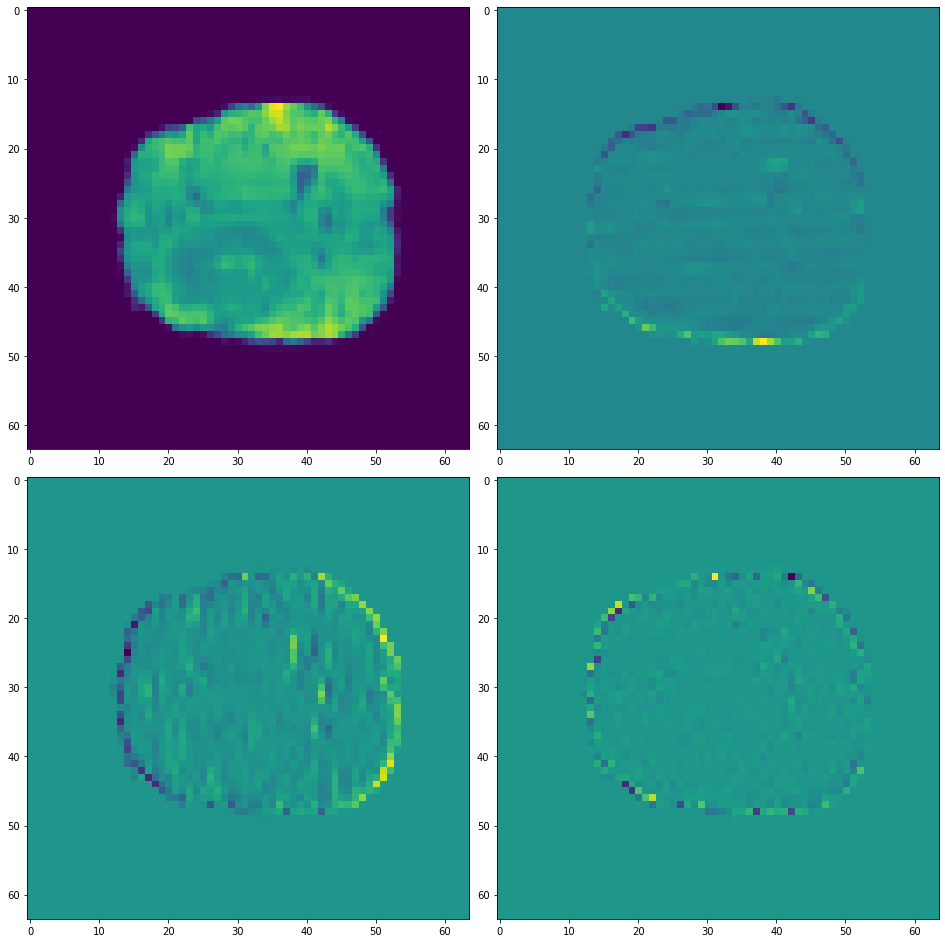

In [14]:
def wavelet_transform(image):
    """Perform a 2D wavelet transform."""
    coeffs = pywt.dwt2(image, wavelet='haar')
    return coeffs

def inverse_wavelet_transform(coeffs):
    """Perform an inverse 2D wavelet transform."""
    image_reconstructed = pywt.idwt2(coeffs, wavelet='haar')
    return image_reconstructed

for batch_X, batch_Y in get_train_scan():

    image = batch_X[77, :, :, 0]
    trans = wavelet_transform(image)

    fig, axs = plt.subplots(2, 2, figsize=(13, 13), constrained_layout=True)

    axs[0, 0].imshow(trans[0])
    axs[0, 1].imshow(trans[1][0])
    axs[1, 0].imshow(trans[1][1])
    axs[1, 1].imshow(trans[1][2])

    plt.show()
    break

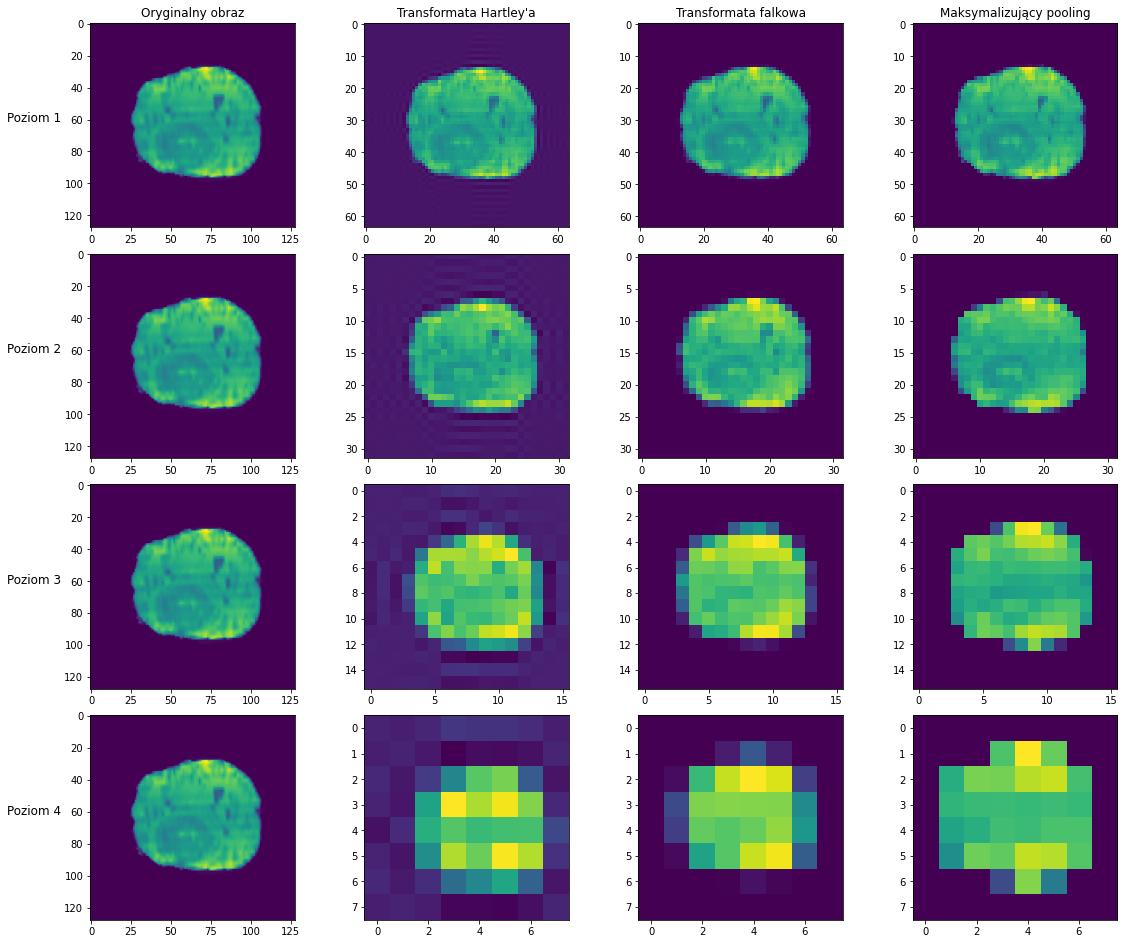

In [38]:
def wavelet_transform(image):
    """Perform a 2D wavelet transform."""
    coeffs = pywt.dwt2(image, wavelet='haar')
    return coeffs[0]

def inverse_wavelet_transform(coeffs):
    """Perform an inverse 2D wavelet transform."""
    image_reconstructed = pywt.idwt2(coeffs, wavelet='haar')
    return image_reconstructed

for batch_X, batch_Y in get_train_scan():

    image = batch_X[77, :, :, 0]
    hartley_image = np.expand_dims(batch_X[77, :, :, 0], axis=[0])
    wavelet_image = batch_X[77, :, :, 0]
    pooling_image = np.expand_dims(image, axis=[0, -1])

    max_pooling = tf.keras.layers.MaxPool2D()

    fig, axs = plt.subplots(4, 4, figsize=(16, 13), constrained_layout=True)

    for i in range(4):

        axs[i][0].imshow(image)
        if i == 0:
            axs[i][0].set_title('Oryginalny obraz')
        axs[i][0].set_ylabel(f'Poziom {i+1}', rotation=0, size='large', labelpad=30)

        hartley_image = SpectralPool2d(scale_factor=(0.5, 0.5))(hartley_image)

        
        axs[i][1].imshow(tf.squeeze(hartley_image))
        if i == 0:
            axs[i][1].set_title("Transformata Hartley'a")


        wavelet_image = wavelet_transform(wavelet_image)

        axs[i][2].imshow(tf.squeeze(wavelet_image))
        if i == 0:
            axs[i][2].set_title('Transformata falkowa')


        pooling_image = max_pooling(pooling_image)

        axs[i][3].imshow(tf.squeeze(pooling_image))
        if i == 0:
            axs[i][3].set_title('Maksymalizujący pooling')

    plt.show()

    break

## Obliczanie odstępów brzegowych

In [ ]:
left_offset, right_offset = [], []
for _, batch_Y in get_train_scan():
    
    for i in range(dataloader.BRAIN_FRAMES):
        if np.any(batch_Y[i, :, :] != 0):
            left_offset.append(i)
            break

    for i in reversed(range(dataloader.BRAIN_FRAMES)):
        if np.any(batch_Y[i, :, :] != 0):
            right_offset.append(i)
            break

print(left_offset)
print(right_offset)

[43, 64, 81, 67, 30, 64, 28, 55, 55, 72, 55, 37, 35, 36, 60, 32, 25, 48, 41, 15, 37, 88, 53, 74, 58, 63, 26, 41, 37, 57, 55, 61, 33, 34, 49, 30, 25, 43, 58, 41, 52, 46, 23, 27, 29, 74, 27, 40, 35, 46, 32, 35, 51, 56, 58, 72, 43, 27, 37, 54, 33, 63, 33, 46, 52, 47, 58, 26, 30, 41, 58, 51, 36, 25, 23, 32, 68, 62, 38, 68, 71, 33, 37, 67, 38, 55, 68, 34, 23, 93, 46, 31, 47, 33, 60, 29, 27, 31, 66, 52, 68, 28, 54, 32, 55, 48, 30, 47, 36, 41, 31, 32, 48, 63, 35, 53, 37, 68, 29, 70, 88, 56, 61, 60, 27, 43, 39, 30, 45, 62, 41, 39, 39, 23, 59, 35, 61, 40, 32, 83, 30, 23, 51, 45, 86, 35, 51, 54, 62, 50, 30, 31, 30, 56, 97, 29, 43, 75, 15, 40, 58, 44, 42, 42, 28, 26, 75, 31, 48, 35, 57, 61, 80, 48, 49, 71, 30, 24, 81, 59, 64, 59, 36, 62, 86, 37, 34, 30, 54, 56, 56, 32]
[118, 131, 130, 134, 110, 137, 107, 135, 136, 132, 121, 91, 79, 87, 114, 97, 83, 116, 102, 94, 112, 131, 137, 139, 107, 116, 89, 100, 87, 101, 135, 138, 85, 93, 126, 112, 70, 131, 109, 127, 93, 112, 72, 113, 88, 134, 114, 113, 136,

In [ ]:
left_offset, right_offset = np.array(left_offset), 155 - np.array(right_offset)

print(pd.Series(left_offset).describe())
print(pd.Series(right_offset).describe())

count    192.000000
mean      46.859375
std       16.867392
min       15.000000
25%       32.750000
50%       44.500000
75%       58.000000
max       97.000000
dtype: float64
count    192.000000
mean      43.630208
std       20.415160
min       13.000000
25%       25.000000
50%       40.500000
75%       59.000000
max      106.000000
dtype: float64


## Obliczenie wag funkcji straty

In [17]:
from collections import Counter

c = Counter()

for path in train_brains:
    path = dataloader.extend_path_from_last_part(path)
    seg = nib.load(f'{path}_seg.nii').get_fdata(dtype=X_DTYPE)

    batch_Y = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE), dtype=Y_DTYPE)

    for i in range(dataloader.BRAIN_FRAMES):
        y_map = dataloader.DataGenerator._map_labels(seg[:, :, i])
        batch_Y[i, :, :] = cv2.resize(y_map, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))

    c.update(batch_Y.flatten())    

In [11]:
c

Counter({0: 482181232, 1: 3155004, 2: 1052469, 3: 1199135})

In [21]:
w = [0] * 4
w_recip_sum = 0
for class_index, class_count in c.items():
    w_recip = 1 / class_count
    w[class_index] = w_recip
    w_recip_sum += w_recip
w = [elem / w_recip_sum for elem in w]
print(w)

[0.0009861144231586264, 0.15070848323856195, 0.45178135170878747, 0.396524050629492]


## Obliczenie maksymalnych wartości w zbiorze

In [17]:
all_brains = train_brains + val_brains + test_brains + unlabeled_brains

In [18]:
dataloader.find_max_per_channel(all_brains)

{'t1': 32767.0, 't1ce': 32767.0, 't2': 32767.0, 'flair': 32767.0}

# Obliczanie wyników testowych

In [ ]:
iou_zero, iou_edema, iou_core, iou_necrotic = [], [], [], []

for batch_X, batch_Y in get_train_scan():

    y_pred = model.predict(batch_X)
    
    for frame_index in range(dataloader.BRAIN_FRAMES):
        
        for class_index in range(NUM_CLASSES):
            
            iou_metric = tf.keras.metrics.OneHotIoU(NUM_CLASSES, [class_index])
            iou_metric.update_state(batch_Y[frame_index], y_pred[frame_index])
            iou_value = iou_metric.result().numpy()
            
            if np.any(batch_Y[frame_index, :, :, class_index] == 1) or np.any(y_pred[frame_index, :, :, class_index] > 0.5):
                is_class_frames = True

            if class_index == 0:
                if is_class_frames:
                    iou_zero.append(iou_value)
                else:
                    iou_zero.append(np.nan)
            elif class_index == 1:
                if is_class_frames:
                    iou_edema.append(iou_value)
                else:
                    iou_edema.append(np.nan)
            elif class_index == 2:
                if is_class_frames:
                    iou_core.append(iou_value)
                else:
                    iou_core.append(np.nan)
            elif class_index == 3:
                if is_class_frames:
                    iou_necrotic.append(iou_value)
                else:
                    iou_necrotic.append(np.nan)
                    
            is_class_frames = False